<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/sgrepo/evaluationGAIsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers accelerate bitsandbytes diffusers

In [ ]:
!wget https://img.freepik.com/free-photo/picture-frame-on-a-wall-with-scandinavian-home-interior_53876-139779.jpg -O /content/room001.jpg

In [ ]:
# /usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py

Oneformer inference

In [32]:
import torch
import os
from PIL import Image
import numpy as np
import cv2
from transformers import OneFormerProcessor, OneFormerModel
from torch import autocast
import json

In [6]:
object_images_dir = "/content/objects"
os.makedirs(object_images_dir, exist_ok=True)

In [ ]:
# load oneformer model
model_id = "shi-labs/oneformer_ade20k_swin_large"
processor = OneFormerProcessor.from_pretrained(model_id)
model = OneFormerModel.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:427: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
img_path = f"/content/room001.jpg"
image = Image.open(img_path)

inputs = processor(image, ["semantic"], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# you can pass them to processor for semantic postprocessing
predicted_semantic_map = processor.post_process_semantic_segmentation(
      outputs, target_sizes=[image.size[::-1]]
)[0]

print(np.unique(predicted_semantic_map))

[  0   3  17  22  23  28  30  36  39  42  64  67 125 135]


In [9]:
target_categories = ["sofa", "table", "cushion", "rug", "chair"]
sub_categories = ["plant", "painting", "vase"]
item_list = model.config.label2id.keys()
include_categories = {}
include_categories["target"] = [model.config.label2id[item] for item in item_list if any(target in item for target in target_categories)]
include_categories["sub"] = [model.config.label2id[item] for item in item_list if any(target in item for target in sub_categories)]

print(include_categories)

{'target': [30, 19, 64, 39, 56, 28, 23, 75, 15], 'sub': [22, 17, 135]}


In [10]:
def calculate_bounding_box(mask_image):
    # Find the indices of non-zero pixels within the mask image
    non_zero_pixels = np.transpose(np.nonzero(mask_image))

    if non_zero_pixels.size == 0:
        # Return an empty Bounding Box if there are no non-zero pixels in the mask
        return None

    # Get x and y coordinates
    x_coords, y_coords = non_zero_pixels[:, 0], non_zero_pixels[:, 1]

    # Calculate the Bounding Box coordinates
    min_x, min_y = np.min(x_coords), np.min(y_coords)
    max_x, max_y = np.max(x_coords), np.max(y_coords)

    return (min_x, min_y, max_x, max_y)

In [26]:
color_list = [
    [255, 0, 0],     # 赤
    [0, 255, 0],     # 緑
    [0, 0, 255],     # 青
    [255, 255, 0],   # イエロー
    [255, 0, 255],   # マゼンタ
    [0, 255, 255],   # シアン
    [128, 0, 128],   # パープル
    [128, 128, 128], # グレー
    [0, 128, 0],     # オリーブ
    [128, 0, 0]      # マルーン
]

color_dict = {}
for idx, t in enumerate(target_categories):
  color_dict[t] = color_list[idx]

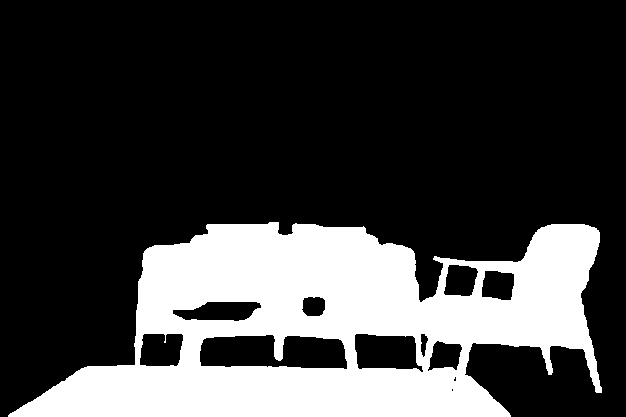

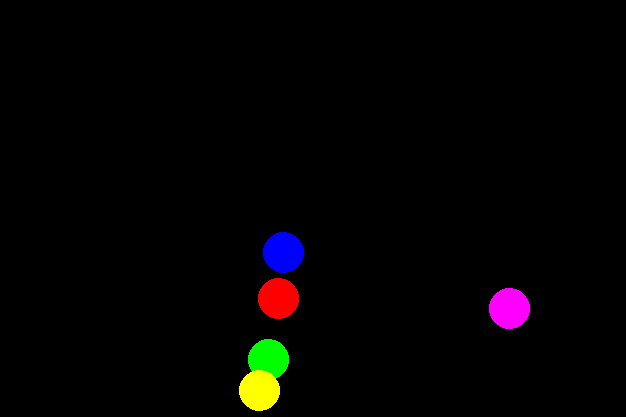

In [35]:
target_base_mask = np.zeros_like(predicted_semantic_map)
total_count = np.prod(target_base_mask.shape)
source_image = cv2.imread(img_path)
bg_image = np.zeros_like(source_image)

os.makedirs(object_images_dir + "/target", exist_ok=True)

label_dict = {}

result_dict = {}

for target_id in include_categories["target"]:
  label_pred_map = np.where(predicted_semantic_map == target_id, 255, 0)
  # bboxのリストと領域の計算
  count = np.count_nonzero(label_pred_map == 255)
  if count > 0:
    bounding_box = calculate_bounding_box(label_pred_map)  # xmin, ymin, xmax, ymax
    mask_ratio = count / total_count
    ymin, xmin, ymax, xmax = bounding_box

    label = model.config.id2label[target_id].split(",")[0].replace(" ", "")
    if label in label_dict.keys():
      label_dict[label] += 1
    else:
      label_dict[label] = 0

    target_color = None
    for cl in color_dict.keys():
      if cl in label:
        target_color = color_dict[cl]

    if target_color is not None:
      center = [int(xmin * 0.5 + xmax * 0.5), int(ymin * 0.5 + ymax * 0.5)]
      cv2.circle(bg_image,
            center=(center[0], center[1]),
            radius=20,
            color=(target_color[0], target_color[1], target_color[2]),
            thickness=-1,
            lineType=cv2.LINE_4,
            shift=0)

      item_dict = {
        "bbox": [int(xmin), int(ymin), int(xmax), int(ymax)],
        "ratio": float(mask_ratio),
        "graph": {
            "label": label,
            "color": target_color,
            "center": center
          }
      }

    result_dict[label] = item_dict

    target_image = source_image[ymin:ymax, xmin:xmax, :]
    cv2.imwrite(object_images_dir + f"/target/{label}_{label_dict[label]}.jpg", target_image)


  target_base_mask += label_pred_map


cv2.imwrite("/content/room001_graph.jpg", bg_image)
json.dump(result_dict, open("/content/room001.json", "w"))
display(Image.fromarray(target_base_mask.astype(np.uint8)))
display(Image.fromarray(bg_image))

0.09913347277449606 (21, 220, 182, 380)
0.0017928149493185005 (216, 35, 266, 98)
0.00332896621999525 (248, 84, 278, 117)


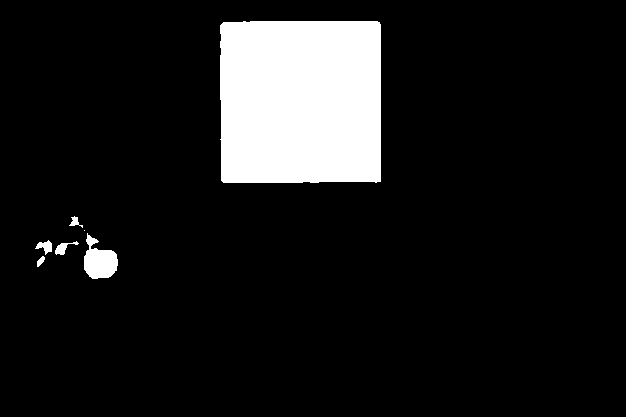

In [22]:
sub_base_mask = np.zeros_like(predicted_semantic_map)
os.makedirs(object_images_dir + "/sub", exist_ok=True)
label_dict = {}
for sub_id in include_categories["sub"]:
  label_pred_map = np.where(predicted_semantic_map == sub_id, 255, 0)
  count = np.count_nonzero(label_pred_map == 255)
  if count > 0:
    bounding_box = calculate_bounding_box(label_pred_map)  # xmin, ymin, xmax, ymax
    print(count / total_count, bounding_box)
    mask_ratio = count / total_count
    ymin, xmin, ymax, xmax = bounding_box

    label = model.config.id2label[sub_id].split(",")[0].replace(" ", "")
    if label in label_dict.keys():
      label_dict[label] += 1
    else:
      label_dict[label] = 0

    target_image = source_image[ymin:ymax, xmin:xmax, :]
    cv2.imwrite(object_images_dir + f"/sub/{label}_{label_dict[label]}.jpg", target_image)
  sub_base_mask += label_pred_map

display(Image.fromarray(sub_base_mask.astype(np.uint8)))